In [1]:
# import modules
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch

import matplotlib.pyplot as plt
import re

In [2]:
data_path = "/home/mingi/data/vistext/data/test_images/vertical"
file_names = sorted(
    os.listdir(data_path), key=lambda x: int(re.search(r"\d+", x).group())
)
model_path = "ahmed-masry/chartgemma"
model_path = "/home/mingi/trained_model"

In [3]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_path, torch_dtype=torch.float16
).cuda()
processor = AutoProcessor.from_pretrained("ahmed-masry/chartgemma")
# Format text inputs

/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def inference_plot(model, processor, input_text, data_path, file_names, idx):

    # Encode chart figure and tokenize text
    image = Image.open(os.path.join(data_path, file_names[idx])).convert("RGB")
    inputs = processor(text=input_text, images=image, return_tensors="pt")
    prompt_length = inputs["input_ids"].shape[1]
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Generate
    generate_ids = model.generate(**inputs, num_beams=4, max_new_tokens=512)
    output_text = processor.batch_decode(
        generate_ids[:, prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(output_text)

    plt.imshow(image)
    plt.axis("off")
    plt.show()


def inference_plot2(model, processor, input_text, data_path, image_name):
    path = "/home/mingi/data/test_charts/img"

    # Encode chart figure and tokenize text
    image = Image.open(os.path.join(path, image_name)).convert("RGB")
    inputs = processor(text=input_text, images=image, return_tensors="pt")
    prompt_length = inputs["input_ids"].shape[1]
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Generate
    generate_ids = model.generate(**inputs, num_beams=4, max_new_tokens=512)
    output_text = processor.batch_decode(
        generate_ids[:, prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(output_text)

    # plt.imshow(image)
    # plt.axis("off")
    # plt.show()

In [ ]:
# Define the path to your txt file
file_path = "ann.txt"

# Initialize an empty list to store the dictionaries
data_list = []

# Open and read the file
with open(file_path, "r", encoding="utf-8") as file:
    # Initialize an empty dictionary to temporarily store each item's data
    current_dict = {}
    query_lines = []  # List to accumulate query lines

    # Loop through each line in the file
    for line in file:
        # Remove leading/trailing whitespace
        line = line.strip()

        if line.startswith("- imagename:"):
            # Append any previous item to the list
            if current_dict:
                # Join the accumulated query lines
                current_dict["query"] = " ".join(query_lines).strip()
                data_list.append(current_dict)

            # Start a new dictionary for the next item
            current_dict = {"imagename": line.split(": ")[1].strip()}
            query_lines = []  # Reset the query lines list

        elif line.startswith("label:"):
            current_dict["label"] = line.split(": ")[1].strip().strip("'")

        elif line.startswith("query:"):
            # Start a new query line accumulation, remove "query:" part
            query_lines = [line.split(": ", 1)[1].strip()]

        else:
            # For continuation of a query across multiple lines
            query_lines.append(line)

    # Append the last dictionary if it exists
    if current_dict:
        current_dict["query"] = " ".join(query_lines).strip()
        data_list.append(current_dict)

# Print the list of dictionaries
print(data_list)

[{'imagename': '30.png', 'label': '50', 'query': 'What was the average ticket price for Nashville Predators games in the 2011/12 season?'}, {'imagename': '30_rot90.png', 'label': '50', 'query': 'What was the average ticket price for Nashville Predators games in the 2011/12 season?'}, {'imagename': '30.png', 'label': '25', 'query': 'How much did the ticket price increase from the 2005/06 season to the 2014/15 season?'}, {'imagename': '30_rot90.png', 'label': '25', 'query': 'How much did the ticket price increase from the 2005/06 season to the 2014/15 season?'}, {'imagename': '30.png', 'label': '2012/13', 'query': 'In which season did the average ticket price first reach 60 U.S. dollars?'}, {'imagename': '30_rot90.png', 'label': '2012/13', 'query': 'In which season did the average ticket price first reach 60 U.S. dollars?'}, {'imagename': '78.png', 'label': 'Singapore', 'query': 'Which country had the highest trade value with India in FY 2019?'}, {'imagename': '78_rot90.png', 'label': 'S

In [ ]:
input_text = "Make a table that corresponds to this chart."
input_text = "Can you extract the data points from the chart in the image and convert them into a JSON format? : {"
input_text = "What was the average ticket price for Nashville Predators games in the 2011/12 season?"
# input_text = "convert the top of chart to a table"
for data in data_list:
    image_name = data["imagename"]
    label = data["label"]
    query = data["query"]
    inference_plot2(model, processor, query, data_path, image_name)

50
50
25
25
2012/13
2012/13
Singapore
Singapore
22000
22000
5
5
2017
2017
3500
3500
7
8
2004/05
2004/05
250
250
10
10
Palmeiras
Palmeiras
550
550
6
6
2015
2015
27
27
7
7
2018
2017
0
0
7
6
2007-2008
2007-2008
-11000
-11000
13
13
2016
2016
1800
1800
3
3
Humira
Humira
27
27
6
6


In [ ]:
def inference_2(model, processor, input_text, data_path, file_name):
    # Encode chart figure and tokenize text
    data_path = "/home/mingi/data/vistext/data/test_images"

    ver_image = Image.open(os.path.join(data_path, "vertical", file_name)).convert(
        "RGB"
    )
    ver_inputs = processor(text=input_text, images=ver_image, return_tensors="pt")
    ver_prompt_length = ver_inputs["input_ids"].shape[1]
    ver_inputs = {k: v.to("cuda") for k, v in ver_inputs.items()}

    hor_image = Image.open(os.path.join(data_path, "horizontal", file_name)).convert(
        "RGB"
    )
    hor_inputs = processor(text=input_text, images=hor_image, return_tensors="pt")
    hor_prompt_length = hor_inputs["input_ids"].shape[1]
    hor_inputs = {k: v.to("cuda") for k, v in hor_inputs.items()}

    # Generate
    generate_ids = model.generate(**ver_inputs, num_beams=4, max_new_tokens=512)
    ver_output_text = processor.batch_decode(
        generate_ids[:, ver_prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(ver_output_text)

    generate_ids = model.generate(**hor_inputs, num_beams=4, max_new_tokens=512)
    hor_output_text = processor.batch_decode(
        generate_ids[:, hor_prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(hor_output_text)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(ver_image)
    axes[0].axis("off")
    axes[1].imshow(hor_image)
    axes[1].axis("off")

    plt.show()

In [ ]:
file_names[11]

'150.png'

| Year | Average monthly data volume per mobile internet subscription (in megabytes) |
|---|---|
| 2009 | 0 |
| 2010 | 50 |
| 2011 | 100 |
| 2012 | 150 |
| 2013 | 200 |
| 2014 | 300 |
| 2015 | 400 |
| 2016 | 600 |
| 2017 | 800 |
| 2018 | 1500 |
| 2019 | 2000 |
| 2020 | 3000 |
| Year | Data volume (in megabytes) |
|---|---|
| 2009 | 20 |
| 2010 | 20 |
| 2011 | 20 |
| 2012 | 20 |
| 2013 | 20 |
| 2014 | 20 |
| 2015 | 20 |
| 2016 | 500 |
| 2017 | 800 |
| 2018 | 1500 |
| 2019 | 2000 |
| 2020 | 3000 |


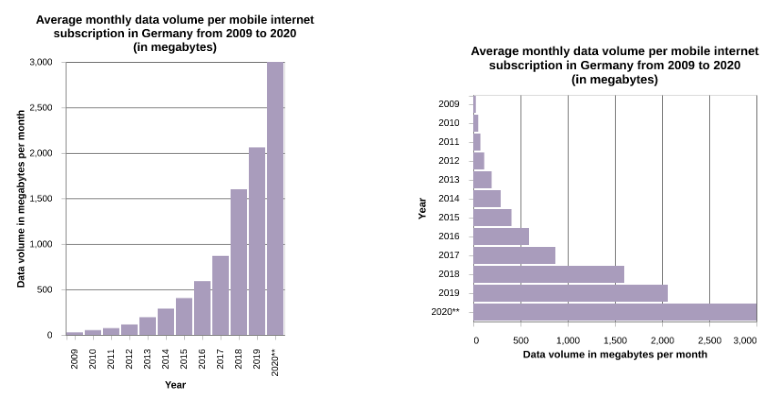

In [ ]:
data_path = "/home/mingi/data/vistext/data/test_images/vertical"
input_text = "What was the average ticket price for Nashville Predators games in the 2011/12 season?"
input_text = "Values in the chart: "
# input_text = "Make a table that corresponds to this chart."
file_names = os.listdir(data_path)
# input_text = "convert the top of chart to a table"
for i, file_name in enumerate(file_names):
    file_name = file_names[500]
    inference_2(model, processor, input_text, data_path, file_name)
    if i == 0:
        break